<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/BaselineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting Drive
The following classifier is designed to discriminate between Mass and Calsification by using baseline images, part of the mammography around the abnormality; hence, it will be a 2-brached model with a single output. The classifier will be built from the pre-trained InceptionV3, due to the fact it worked well as pre-trained model in the single entry network. The model will be submited to evaluation in order to improve its flatten version.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3

from google.colab import output
from google.colab import drive

#Mounting drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

Mounted at /content/gdrive


#Load Data
Training set

In [ ]:
img = np.load(base_path+'dataset/train_tensor.npy') 
labels = np.load(base_path+'dataset/train_labels.npy') 
depth, width, height = img.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label
classLabel = ["Mass", "Calcification"]

#Pre-Processing Data
Since this classifier is InceptionV3, it means the entry of the network have to be converted to 3-channel image. In this section, both the abnormality image and the baseline image are casted from the monochromacy into 3-channel image by simple copying the unique existing channel.

In [ ]:
labels_train = np.array([]);
idx = [];
idx_baseline = [];

# Extraction of Mass and Calcificacion from the dataset
for i in range(depth):
  if ((labels[i] == 1) or (labels[i] == 2)):    # mass
    idx.append(i)
    idx_baseline.append(i - 1)
    labels_train = np.append(labels_train, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)):  # calcification
    idx.append(i)
    idx_baseline.append(i - 1)
    labels_train = np.append(labels_train, [1]);


# Filter the abnormal images    
img2 = img[idx];
img2_bl = img[idx_baseline]
depth = idx.__len__()

# Triple the black and white colour to a 3-colour channel 
img = np.zeros((depth, width, height, 3))
img_bl = np.zeros((depth, width, height, 3))

for i in range(depth):
  img[i, :, :, 0] = img2[i]
  img[i, :, :, 1] = img2[i]
  img[i, :, :, 2] = img2[i]

  img_bl[i, :, :, 0] = img2_bl[i]
  img_bl[i, :, :, 1] = img2_bl[i]
  img_bl[i, :, :, 2] = img2_bl[i]
  
# Normalization
img = img.astype('float32') / 65535;
img_bl = img_bl.astype('float32') / 65535;

#Plot Some Sample

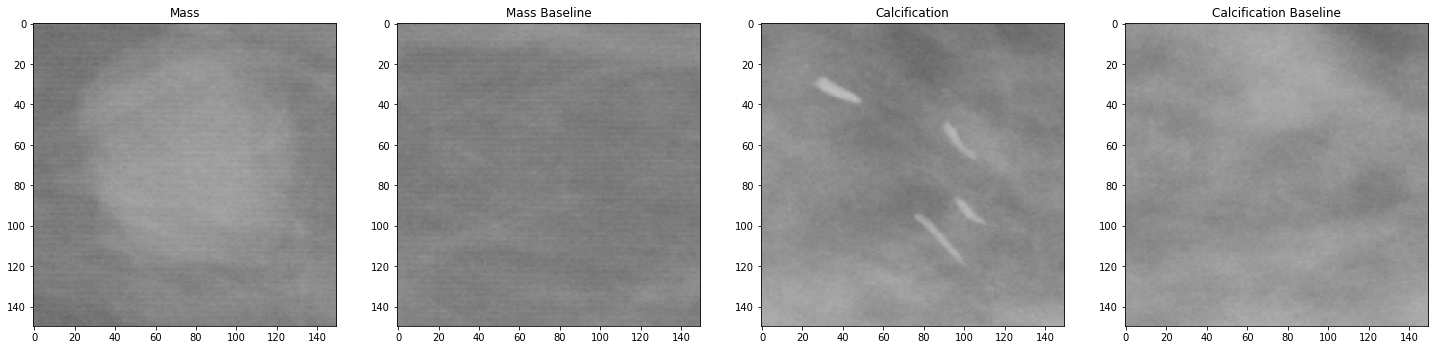

In [ ]:
toPlot = np.random.randint(depth, size = 2)

plt.figure(figsize=(25, 10))
for x in range(toPlot.__len__()):
  plt.subplot(1, 4, 2*x+1)
  plt.imshow(img[toPlot[x]])
  plt.title(classLabel[np.int_(labels_train[toPlot[x]])])

  plt.subplot(1, 4, 2*x + 2)
  plt.imshow(img_bl[toPlot[x]])
  plt.title(classLabel[np.int_(labels_train[toPlot[x]])] + " Baseline")

#Helper Function


In [ ]:
def reset_weights(md):
  # Resets the weights of the model
  session = backend.get_session()
  for layer in md.layers:
      backend.clear_session()

def loadResultMetrics(fileName):
  # Load metric files
  a = np.load(fileName)
  return a[0], a[1], a[2], a[3]

def BotNotifier(message):
    # Sends "message" across a telegram bot 
    TOKEN = "995731858:AAHrY8FYsa0sE6zKkRGtkZgdLo7-VDjvORo"
    CHAT_ID = "597192342"
    URL = "https://api.telegram.org/bot{}/".format(TOKEN)
    url = URL + "sendMessage?text={}&chat_id={}".format(message, CHAT_ID)
    response = requests.get(url)

def PlotFiles(arg):
  # plots n = len(arg) learning curves: Train/Validation Accuracy/Loss
  plt.figure(figsize=(25, 8))

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  for files in arg:
    if files is not None:
      acc, loss, val_acc, val_loss = loadResultMetrics(os.path.join(metrics_path, files))
      plt.subplot(1, 2, 1)
      plt.plot(acc, label = 'Train ' + files)
      plt.plot(val_acc, label = 'Val acc ' + files)
      plt.subplot(1, 2, 2)
      plt.plot(loss, label="Training loss " + files)
      plt.plot(val_loss, label="Val loss " + files)

  plt.subplot(1, 2, 1)
  plt.grid()
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.grid()
  plt.legend()

#General Parameters

In [ ]:
k = 5;      # this represents the 20 % of data set provided
EPOCH = 50  # Epochs per training
BATCH = 64  # Size of the batch
learning_rate = 0.0001 # Learning Rate
save_model = True       # variable to enable/disable the saving of generated model
times2run_trainer = 1   # Times the trainer will run on the same (the model restarts between trainings)

#Double Entry Network 

##Generator Joiner
The network will be trained using augmented data. The default ImageGenerator from the Keras API is only capable to generate one entry image, that's why, a function that bonds the abnormality image generator and the  baseline image genetator class is implemented.

In [ ]:
class JoinedSiames_Generators(Sequence):
  def __init__(self, abnormal_gen, baseline_gen):
    self.in_abnormal_gen = abnormal_gen
    self.in_baseline_gen = baseline_gen

    assert len(abnormal_gen) == len(baseline_gen)

  def __len__(self):
    return len(self.in_abnormal_gen)

  def __getitem__(self, i):
    x1, y = self.in_abnormal_gen[i]
    x2 = self.in_baseline_gen[i]
    return [x1, x2], y

  def on_epoch_end(self):
    self.in_abnormal_gen.on_epoch_end()
    self.in_baseline_gen.on_epoch_end()

### Trainner and K-Fold
The model will be trained using 5-fold cross-validation algorithm 

In [ ]:
def runModel_generator_w_KFold(model, img_abn, img_bl, labels_train, optmz, kFold, epoch, batch_size):
  # Implements K-Fold Algorithm
  depth, _, _, _ = img_abn.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Generators
  train_datagen_abnormality = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )
  
  train_datagen_baseline = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )

  valid_datagen_abnormality = ImageDataGenerator(rescale=1.)
  valid_datagen_baseline = ImageDataGenerator(rescale=1.)
  
  # Model Compilation
  model.compile(optimizer = optmz, loss="mse", metrics = ['accuracy'])
  model.save_weights(base_path+'task4_Siamese.h5')

  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Generator for training
    train_generator_abnormality = train_datagen_abnormality.flow(img_abn[train], 
                                                                 labels_train[train], 
                                                                 batch_size=batch_size,
                                                                 shuffle=False)
    
    train_generator_baseline = train_datagen_baseline.flow(img_bl[train], 
                                                              batch_size=batch_size,
                                                              shuffle=False)
    # Generator for validation
    valid_generator_abnormality = valid_datagen_abnormality.flow(img_abn[valid], 
                                                     labels_train[valid],
                                                     shuffle=False)
    valid_generator_baseline = valid_datagen_baseline.flow(img_bl[valid],
                                                     shuffle=False)
    # Joining genetators
    train_generator = JoinedSiames_Generators(train_generator_abnormality, 
                                              train_generator_baseline)
    valid_generator = JoinedSiames_Generators(valid_generator_abnormality, 
                                              valid_generator_baseline)

    model.load_weights(base_path+'task4_Siamese.h5')

    # Train
    h = model.fit(train_generator,
                  steps_per_epoch=np.ceil(train.shape[0]/batch_size), epochs=epoch, 
                  validation_data=valid_generator, validation_steps=np.ceil(valid.shape[0]/batch_size), 
                  verbose=0)    
    
    # Log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])
    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')
    reset_weights(model)

    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))
  
  # Average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  return acc, loss, val_acc, val_loss, val_acc_int/5.0

def trainerNtimes_generator_saveInitModel(n_times, genModelx, arg, img_abn, img_bl, 
                                          labels_train, lr, k, EPOCH, BATCH, saveIt, fileName, isFT):
  # The Model can be trainned many times
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Send message a training has started
  BotNotifier("Starting BaselineCNN with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    #define optimizer
    adam = Adam(lr=lr);

    # define model
    model = genModelx(arg);

    # run 5-fold algorithm
    a, b, c, d, aba = runModel_generator_w_KFold(model, img_abn, img_bl, labels_train, adam, k, EPOCH, BATCH)
    
    # remove model and optimizer
    del model
    del adam

    # Log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)

  # Average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # Save metrics
  if (saveIt): 
    np.save(fileName + ".npy", np.stack((acc, loss, val_acc, val_loss)))

  # Send message the train is done
  BotNotifier("Done on BaselineCNN with " + str(arg) + " ABA: " + str(aba));
  return acc, loss, val_acc, val_loss

#Model
The proposed isnt strictly a siamese network. Firstly the pre-trained model will be used only as a feature extractor, this is a siamese network by definition. In the second part, the model will be fine-tuned in order to adjust the kernels of the pre-trained model and increase the performace, which was seen working really well in the last two classifiers designed from a pre-trained model; so, the model isnt a siamese network anymmore, even they have the same architecture they have different weight values.

In [ ]:
def baseline_model(base_model):
  # Define double Input
  input_1 = Input(shape=(width, height, 3))
  input_2 = Input(shape=(width, height, 3))

  # Double Output, one per each Input
  x1 = base_model(input_1)
  x2 = base_model(input_2)

  # Concatenate the 2 ouputs
  concat_vector = layers.concatenate([x1, x2], axis=-1, name='concat')

  # Flat the output
  flat1 = layers.Flatten()(concat_vector)
  # Add a new output for binary classification
  output = layers.Dense(1, activation='sigmoid')(flat1)

  model2return = models.Model([input_1, input_2], outputs=output)

  model2return.summary()

  return model2return

##Load InceptionV3

In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

##Train Concatenated Layer

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7ff8276eecf8>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


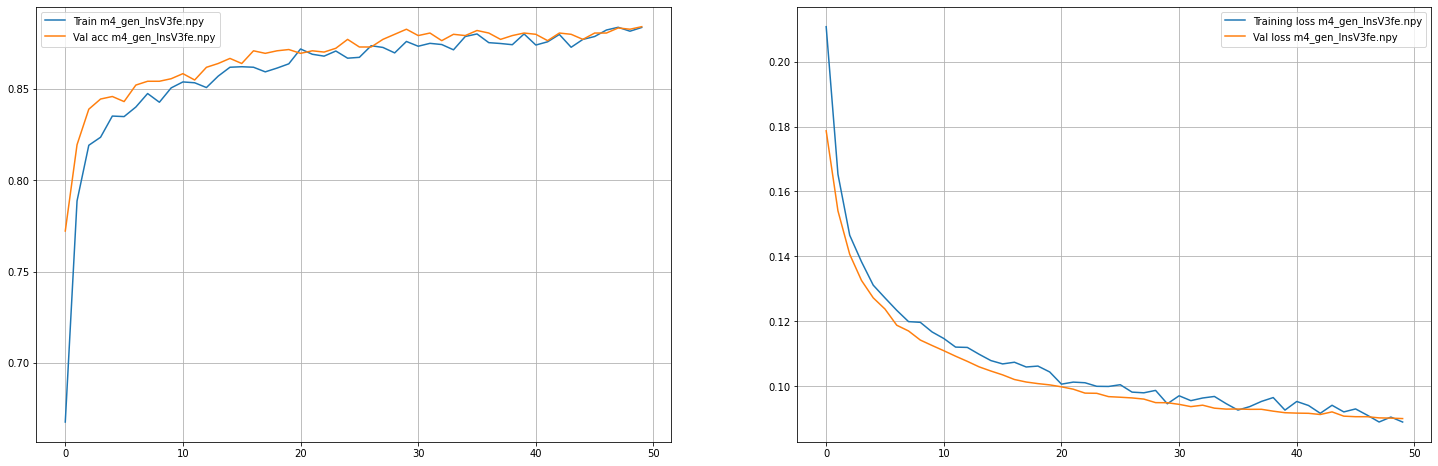

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model,
                                      pre_trained_model, img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3fe"))
PlotFiles(("m4_gen_InsV3fe.npy", None))

###Fine Tuning

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7ff8276eecf8>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

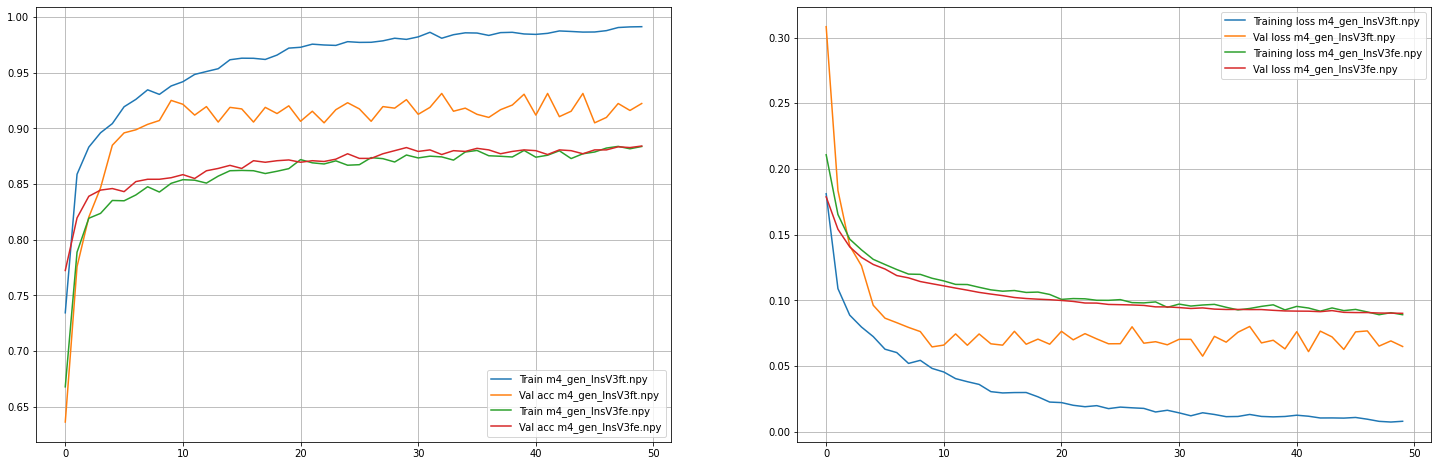

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model,
                                      pre_trained_model, img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3ft"))
PlotFiles(("m4_gen_InsV3ft.npy", "m4_gen_InsV3fe.npy"))

As expected the fine-tuned model performed better; however, this means that model is trained in two-stages: First the model only trains the concatenated layer by keeping fixed the pre-trained models. 

From the learnin curve it's visible the over fitting starting at epoch 10, in order to avoid it a dropout layer will be placed after concatenating the networks. From previous experience, adding a dense layer for this 2-class classifier is not gonna work.

#Dropout Model
This model is generates a dropout model with a desire dropping-out range

In [ ]:
def baseline_model_dropout(base_model):
  # Define double Input
  input_1 = Input(shape=(width, height, 3))
  input_2 = Input(shape=(width, height, 3))

  # Double Output, one per each Input
  x1 = base_model[0](input_1)
  x2 = base_model[0](input_2)

  # Concatenate the 2 ouputs
  concat_vector = layers.concatenate([x1, x2], axis=-1, name='concat')

  # Flat the output
  flat1 = layers.Flatten()(concat_vector)
  dropout1 = layers.Dropout(base_model[1])(flat1)
  # Add a new output for binary classification
  output = layers.Dense(1, activation='sigmoid')(dropout1)

  model2return = models.Model([input_1, input_2], outputs=output)

  model2return.summary()

  return model2return

##50% Dropout
In the first experiment the model will be evaluated with a dropping rate of 50%. As usual, it's a two stage training, first feature extractor, then, fine-tuning.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8f4d3a7358>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

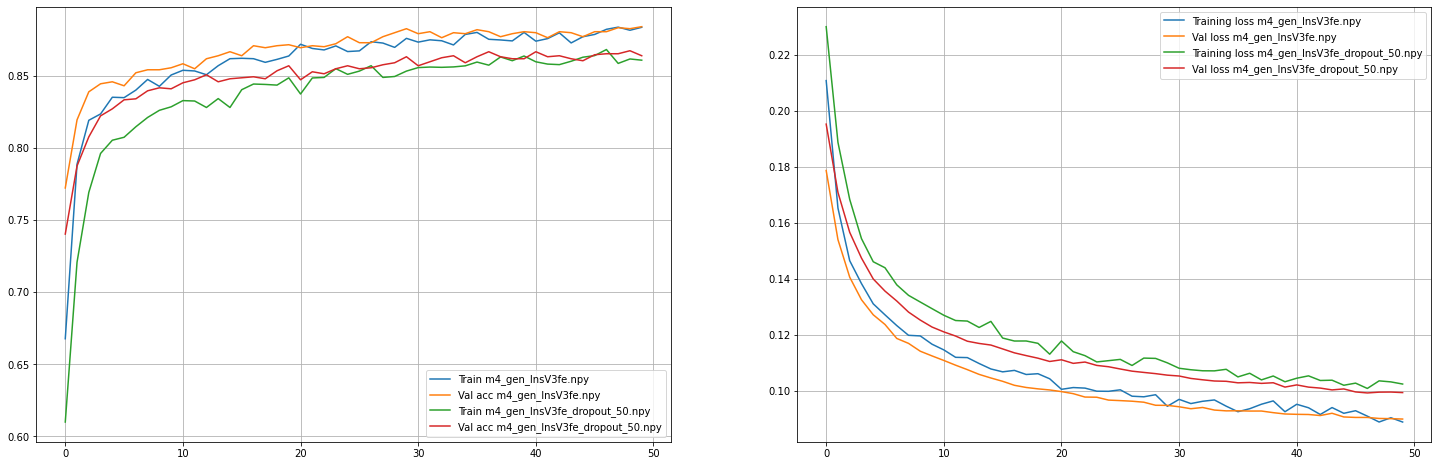

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model_dropout,
                                      (pre_trained_model, 0.5), img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3fe_dropout_50"))
PlotFiles(("m4_gen_InsV3fe.npy", "m4_gen_InsV3fe_dropout_50.npy"))

###Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8f4d3a7358>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

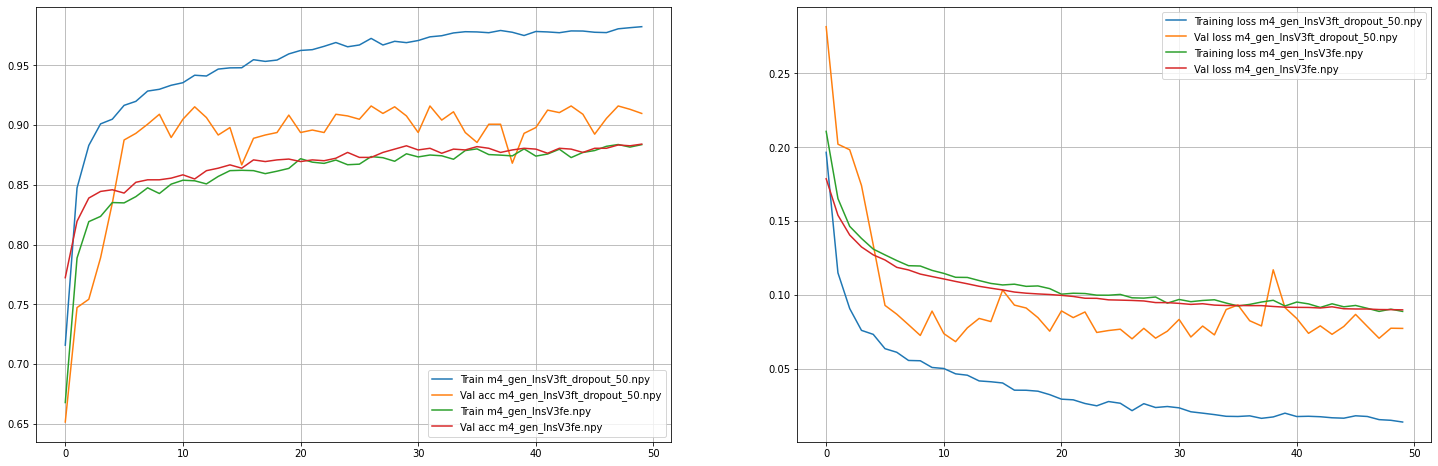

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model_dropout,
                                      (pre_trained_model, 0.5), img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3ft_dropout_50"))
PlotFiles(("m4_gen_InsV3ft_dropout_50.npy", "m4_gen_InsV3fe.npy"))

### Fair Comparison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

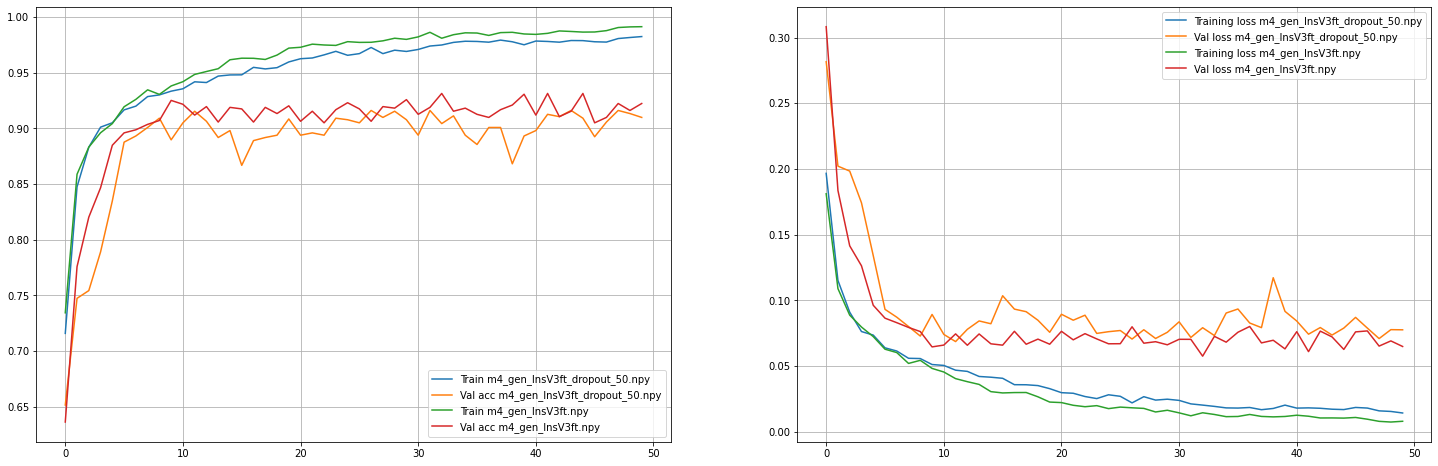

In [ ]:
PlotFiles(("m4_gen_InsV3ft_dropout_50.npy", "m4_gen_InsV3ft.npy"))

The learnig curves from the 50% dropping rate have decreased the model's performance. From previous experience, if this high dropping rate aggravates the net's performance then, it was too much dropping. 

##25% Dropout

Since the 50% was to much, in this experiment the network, the dropping ratio is set to 25%. as usual, the training is in two stages.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8f4d33c978>, 0.25)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

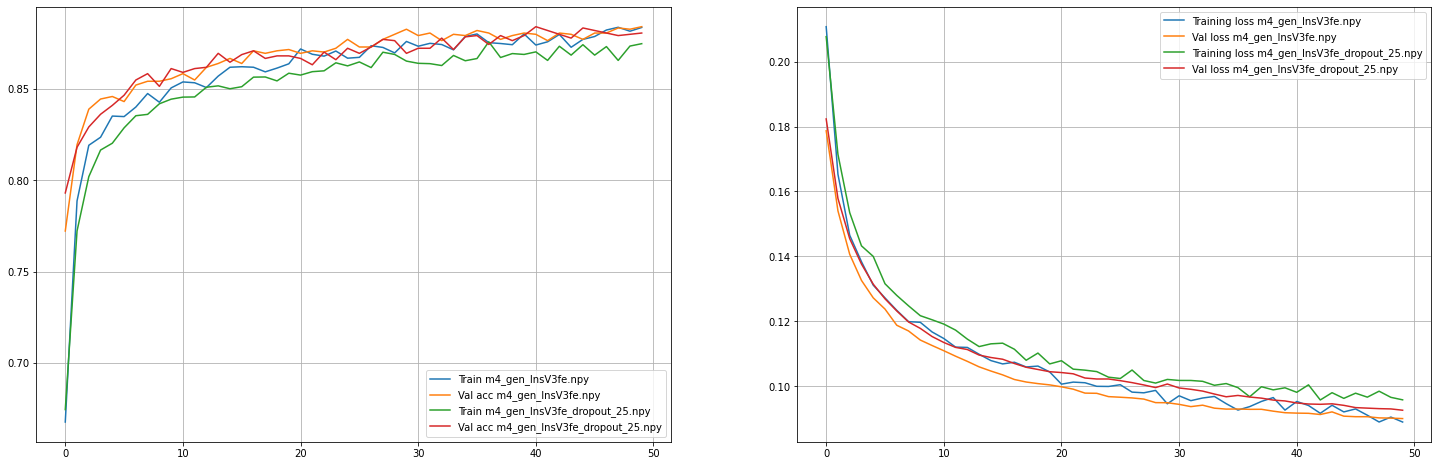

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model_dropout,
                                      (pre_trained_model, 0.25), img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3fe_dropout_25"))
PlotFiles(("m4_gen_InsV3fe.npy", "m4_gen_InsV3fe_dropout_25.npy"))

###Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8f4d33c978>, 0.25)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

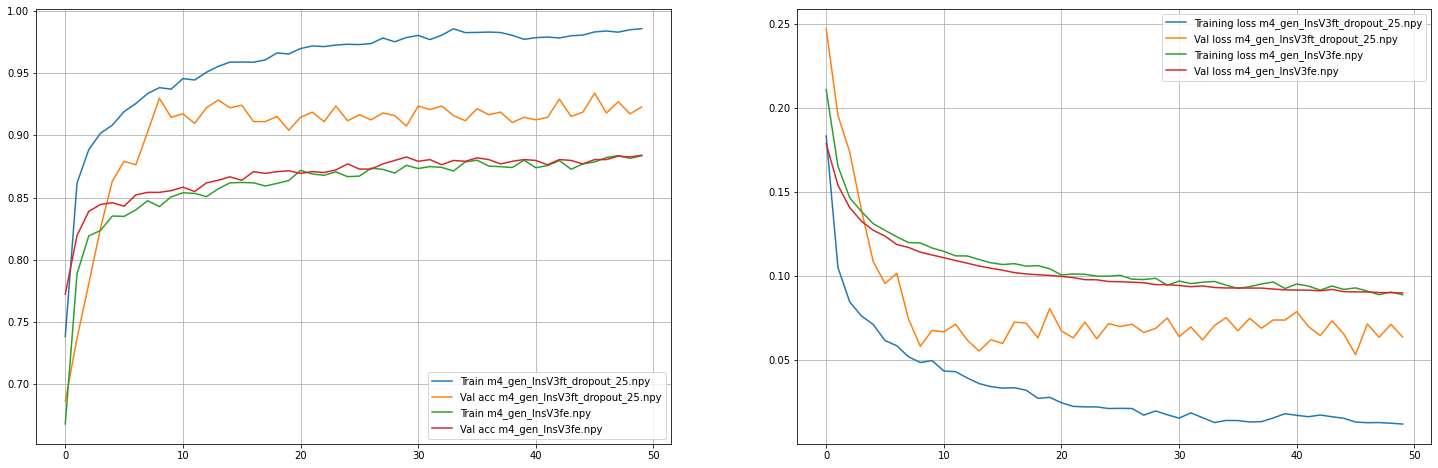

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, baseline_model_dropout,
                                      (pre_trained_model, 0.25), img, img_bl, labels_train, 
                                      learning_rate, k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m4_gen_InsV3ft_dropout_25"))
PlotFiles(("m4_gen_InsV3ft_dropout_25.npy", "m4_gen_InsV3fe.npy"))

# Release memory
del pre_trained_model

### Fair Comparison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

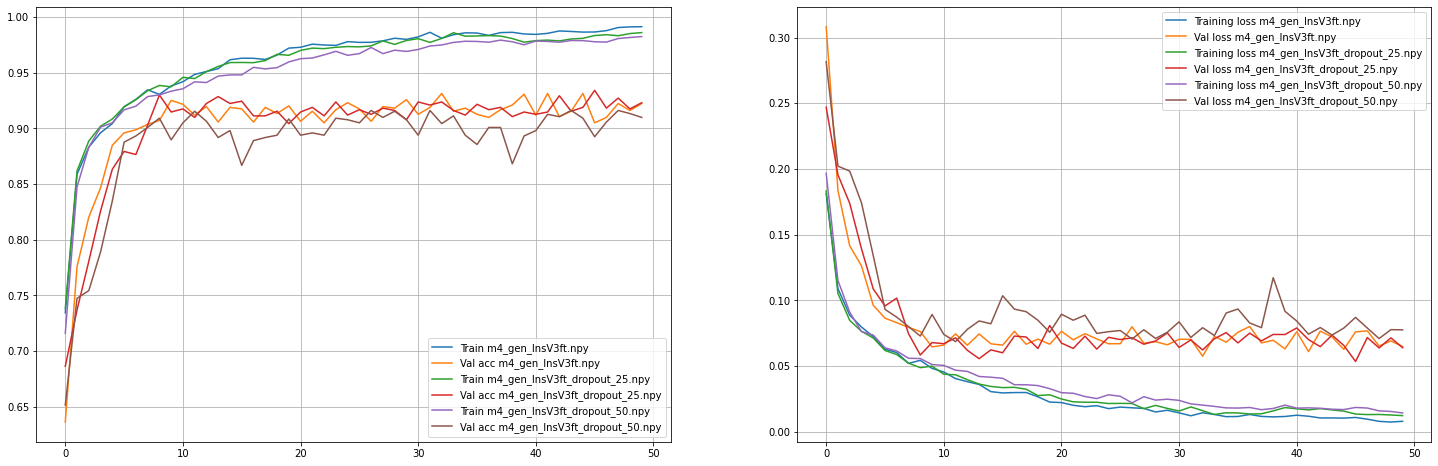

In [ ]:
PlotFiles(("m4_gen_InsV3ft.npy", "m4_gen_InsV3ft_dropout_25.npy", "m4_gen_InsV3ft_dropout_50.npy", ))

There exists indeed an advantage of the 25% dropping model over the 50% model and over concatenated-only model in terms of accuracy, loss and learning speed.

#Ultimate Training
Finally the 25% dropping rate model will be trained but before, the validation confusion matrix will be computed, this will be usefull for the Ensemble task.

## Validation Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def trainModel_w_kFold_n_aug_confusion_mm(model, img_abn, img_bl, labels_train, optmz, kFold, epoch, batch_size, model_name):  
  # Implements K-Fold Algorithm
  depth, _, _, _ = img_abn.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Generators
  train_datagen_abnormality = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )
  
  train_datagen_baseline = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )
  
  # Model Compilation
  model.compile(optimizer = optmz, loss="mse")
  model.save_weights(base_path+'task4_Siamese_cm.h5')

  val_acc = 0.0  
  cmm = np.zeros([2, 2])

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Generators Setting
    train_generator_abnormality = train_datagen_abnormality.flow(img_abn[train], 
                                                                 labels_train[train], 
                                                                 batch_size=batch_size,
                                                                 shuffle=False)
    
    train_generator_baseline = train_datagen_abnormality.flow(img_bl[train], 
                                                              batch_size=batch_size,
                                                              shuffle=False)

    train_generator = JoinedSiames_Generators(train_generator_abnormality, train_generator_baseline)

    # Load same model for all 5 folds
    model.load_weights(base_path+'task4_Siamese_cm.h5')

    # Train
    h = model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                  epochs=epoch, verbose=0)
        
    # Validation Confusion Matrix
    aux = model.predict([img_abn[valid], img_bl[valid]])
    y_pred = np.zeros(aux.shape)
    y_pred[aux >= 0.5] = 1
    cmm = cmm + confusion_matrix(labels_train[valid], y_pred, [0, 1])
    val_acc = val_acc + accuracy_score(labels_train[valid], y_pred)

    print('=> val acc:', accuracy_score(labels_train[valid], y_pred))
    print('DONE------------------------------------------------------------------------------------------')

    reset_weights(model)
    
  cmm_norm = np.sum(cmm)
  
  print("Overall val_acc: ", val_acc / (1.*kFold))
  
  return cmm/cmm_norm, val_acc / (1.*kFold)

def trainerNtimes_generator_confusion_mm(n_times, genModelx, arg, img, img2, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs the k-fold algorith over the same model

  # metrics vector
  cmm = []
  val_acc = []

  # bot notifies a training has started
  BotNotifier("Starting BaselineCNN with " + str(arg))


  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Creates optimizer and model
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # calls k-fold algorithm
    a, b = trainModel_w_kFold_n_aug_confusion_mm(model, img, img2, labels_train, adam, k, EPOCH, BATCH, fileName)
    
    # release model
    del model
    del adam

    # log metrics
    cmm.append(a)
    val_acc.append(b)

  # average metrics
  cmm = np.average(cmm, axis=0)
  val_acc = np.average(val_acc, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName, np.stack(cmm))

  # bot notifies, training is done
  BotNotifier("Done on BaselineCNN with " + str(arg))

  return cmm, val_acc


def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # plot n = len(cm) confusion matrix files in a nx2 subplot organization
  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

Control Confusion Matrix

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 



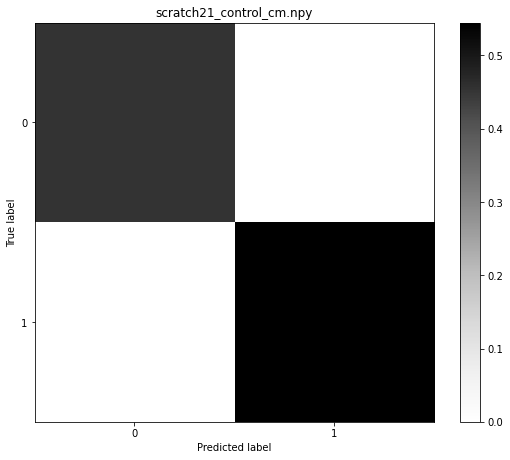

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", None), 2, [0, 1])

**Validation Confusion Matrix** Compute the confusion of the model at validation stage, therefore, it's validation precision per class is known.

In [ ]:
#del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = True

In [ ]:
trainerNtimes_generator_confusion_mm(times2run_trainer, baseline_model_dropout, (pre_trained_model, 0.25), 
                           img, img_bl, labels_train, learning_rate, k, 13, 
                           BATCH, save_model, os.path.join(metrics_path, "task4_InsV3ft_model_cm.npy"))
del pre_trained_model

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f3fd8054278>, 0.25)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________

(array([[0.40934579, 0.04598131],
        [0.04299065, 0.50168224]]), 0.9110280373831776)

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 

task4_InsV3ft_model_cm.npy
=> [[0.40934579 0.04598131]
 [0.04299065 0.50168224]] 



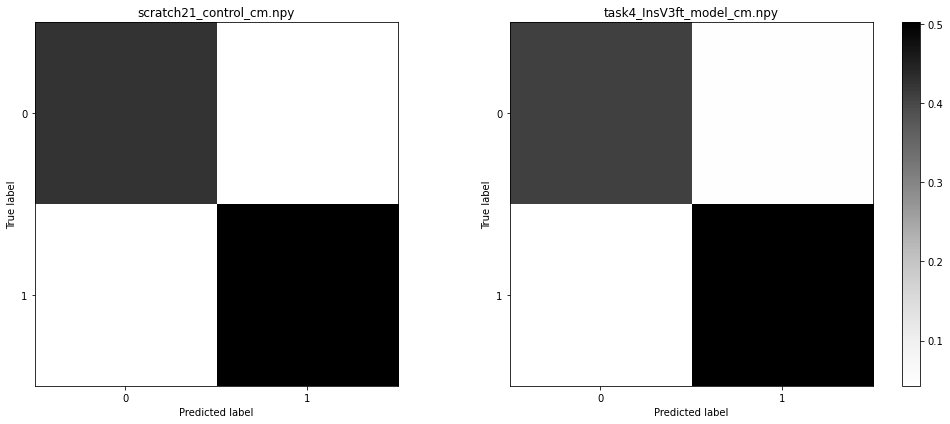

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", "task4_InsV3ft_model_cm.npy"), 2, [0, 1])

## Training
The model is train this time with whole data set by batches defined in BATCH and early stopping technique, epoch when the minimum loss was found.

In [ ]:
def train_only(modelFoo, arg, lr, img_abn, img_bl, labels_train, epoch, batch_size, model_name):
  # Compile Model
  model = modelFoo(arg)
  adam = Adam(lr=lr)
  model.compile(optimizer=adam, loss='mse')

  # Generators for abnormality and baseline
  train_datagen_abnormality = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )
  
  train_datagen_baseline = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )
  
  # flowers for abnormality and baseline
  train_generator_abnormality = train_datagen_abnormality.flow(img_abn, 
                                                               labels_train, 
                                                               batch_size=batch_size,
                                                               shuffle=False)
    
  train_generator_baseline = train_datagen_abnormality.flow(img_bl, 
                                                            batch_size=batch_size,
                                                            shuffle=False)

  # joining generators 
  train_generator = JoinedSiames_Generators(train_generator_abnormality, train_generator_baseline)

  # Train
  model.fit(train_generator, steps_per_epoch=np.ceil(labels_train.shape[0]/batch_size),
            epochs=epoch, verbose=1)

  # Save Model
  print('Model Save at:', base_path+model_name)
  model.save(base_path+weights2load)
  
  # Release memory
  del model
  del adam 

def loadModel_fromFile(model2load):
  return models.load_model(base_path+model2load)

In [ ]:
del pre_trained_model

As mentioned above, the training is a two stages training, first only the Concatenated layer, then, the fine-tuning for adjusting the pre-trained models weights.

In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 
pre_trained_model.trainable = False

# Feature extractor only 
train_only(baseline_model_dropout, (pre_trained_model, 0.25), learning_rate, img, img_bl, labels_train, 50, BATCH, "task4_fe_model.h5")

# Release memory
del pre_trained_model

# Fine-Tuning
train_only(loadModel_fromFile, "task4_fe_model.h5", learning_rate, img, img_bl, labels_train, 14, BATCH, "task4_ft_model.h5")

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 3, 3, 2048)   21802784    input_59[0][0]                   
                                                                 input_60[0][0]                   
__________________________________________________________________________________________________
concat (Concatenate)            (None, 3, 3, 4096)   0           inception_v3[0][0]        

#Test
In this section the model 50% dropout is submited to test with images that has not seen yet.

##Load test dataset

In [ ]:
img_test = np.load(base_path+'dataset/public_test_tensor.npy') 
labels = np.load(base_path+'dataset/public_test_labels.npy') 
depth_test, width_test, height_test = img_test.shape 

Preprocessing test data, due to the InceptionV3's entry requirements, the monochromatic mammographies are casted into a 3-channel image by copying the same channel in the other 2 channels.

In [ ]:
labels_test = np.array([]);
idx = [];
idx_baseline = [];

# Extraction of Mass and Calcificacion from the dataset
for i in range(depth_test):
  if ((labels[i] == 1) or (labels[i] == 2)):    # mass
    idx.append(i)
    idx_baseline.append(i - 1)
    labels_test = np.append(labels_test, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)):  # calcification
    idx.append(i)
    idx_baseline.append(i - 1)
    labels_test = np.append(labels_test, [1]);

# Filter the abnormal images    
img2_test = img_test[idx];
img2_bl_test = img_test[idx_baseline];
depth_test = idx.__len__()

# Triple the black and white colour to a 3-colour channel 
img_test = np.zeros((depth_test, width_test, height_test, 3))
img_bl_test = np.zeros((depth_test, width_test, height_test, 3))

for i in range(depth_test):
  img_test[i, :, :, 0] = img2_test[i]
  img_test[i, :, :, 1] = img2_test[i]
  img_test[i, :, :, 2] = img2_test[i]
  
  img_bl_test[i, :, :, 0] = img2_bl_test[i]
  img_bl_test[i, :, :, 1] = img2_bl_test[i]
  img_bl_test[i, :, :, 2] = img2_bl_test[i]
  
# Normalization
img_test = img_test.astype('float32') / 65535;
img_bl_test = img_bl_test.astype('float32') / 65535;

##Model Under Test
Load the trained model from file

In [ ]:
mut = models.load_model(base_path+'models/task4_ft_model.h5')

In [ ]:
aux = mut.predict([img_test, img_bl_test])
y_test = np.zeros(aux.shape)
y_test[aux >= 0.5] = 1
cmm = confusion_matrix(labels_test, y_test)
cmm = cmm/np.sum(cmm)

# Save Test confusion matrix
np.save(os.path.join(metrics_path, "task4_test_cm.npy"), np.stack(cmm))
# Save y_test for task5: ensemble network
np.save(os.path.join(metrics_path, "task4_y_test_output_label.npy"), np.stack(aux))
print("ACCURACY TEST: ", accuracy_score(labels_test, y_test))
# Release memory
del mut

ACCURACY TEST:  0.8422619047619048


The test confusion metrics is compared to the test control confusion matrix, and we conclude that the networks does good at identifying masses but not, at identifying calcifications.

**Precision for Mass** = 0.849984

**Precision for Calfication** = 0.83

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 

task4_test_cm.npy
=> [[0.45535714 0.07738095]
 [0.08035714 0.38690476]] 



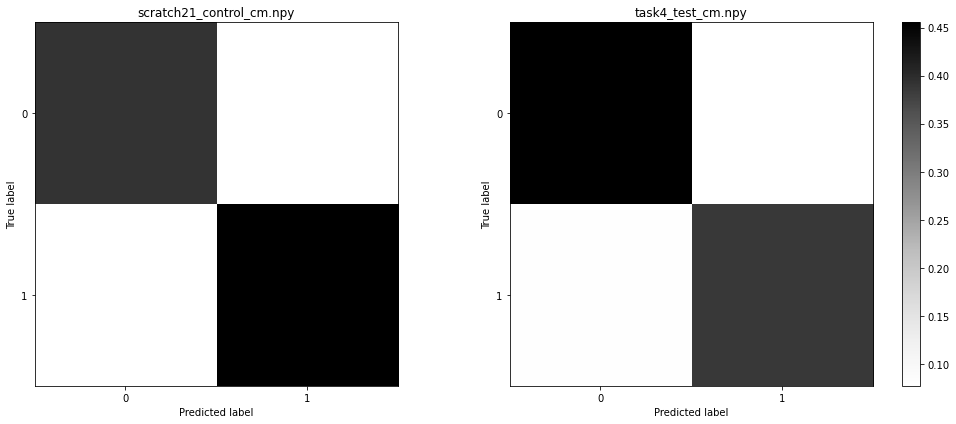

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", "task4_test_cm.npy"), 2, [0, 1])